# Integral Equation Model Comparisons
Purpose of this notebook is to EOS calculations for comparisons to George Petrov's Average Atom model, and Morales EOS Hydrogen paper

[https://journals.aps.org/pre/abstract/10.1103/PhysRevE.81.021202](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.81.021202)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv

from hnc.hnc.PIE import Plasma_of_Ions_and_Electrons as PLASMA

from hnc.hnc.constants import *
from hnc.hnc.misc import n_from_rs, rs_from_n, P_Ideal_Fermi_Gas, E_Ideal_Fermi_Gas 


prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
                
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}

</style>
""")

#### Load George Data

In [7]:
GP_H_file = "H-rho=1.dat"
GP_df = read_csv(GP_H_file, delim_whitespace=True, header=0)
GP_PMbar_1 = GP_df['P_ishikawa'][3:]
GP_PMbar_2 = GP_df['P_fauss'][3:]
GP_Te_eV = GP_df['Te'][3:]

In [8]:
# GP_df

#### Load Morales Data

In [9]:
Morales_file = "Morales_EOS_data.dat"
Morales_df = read_csv(Morales_file, delim_whitespace=True, header=4)
Morales_EAU  = Morales_df['E[AU]']
Morales_PGPa = Morales_df['P[GPa]']
Morales_TK   = Morales_df['T[K]']
Morales_PMbar =  1e-2*Morales_PGPa
Morales_TeV = Morales_TK/eV_to_K

In [10]:
# Morales_df
# Morales_EAU*AU_to_eV

#### Load atoMEC data

In [11]:
atoMEC_file = "atoMEC_H_pressures.dat"
atoMEC_df = read_csv(atoMEC_file, delim_whitespace=True, header=0)
atoMEC_TeV = atoMEC_df['T[eV]']
atoMEC_PAU = atoMEC_df['P[AU]']
atoMEC_PMbar = atoMEC_PAU*AU_to_bar/1e6
# atoMEC_df

### Set Parameters in Paper and Plot

In [12]:
name = 'Hydrogen'
Z, A = 1,1 

Te_eV_list = np.geomspace(np.min(Morales_TeV), np.max(GP_Te_eV), num=15) #np.array(GP_Te_eV) # eV
Ti_eV_list = Te_eV_list
ni_cc = 5.98e23
ni_AU = ni_cc/cm_to_AU**3

ri_cm = rs_from_n(ni_cc)  # cm
ri_AU = ri_cm*cm_to_AU    # AU 

#### Run Ornstein-Zernike Closure

In [67]:
def plasma_output(plasma):
    plasma.run_hnc()
    try: 
        plasma.hnc.βu_r_matrix[1,1] -= plasma.βP_ee
    except:
        plasma.hnc.βu_r_matrix[1,1] -= plasma.qsp.βv_Pauli(plasma.hnc.r_array, plasma.qsp.Λee)
    # Make pressures
    Pe_hnc_id, Pe_hnc_ex   = plasma.hnc.rho[1]*plasma.hnc.Temp_list[1],  np.sum( plasma.hnc.excess_pressure_matrix(),axis=1 )[1] 
    Pi_hnc_id, Pi_hnc_ex   = plasma.hnc.rho[0]*plasma.hnc.Temp_list[0],  np.sum( plasma.hnc.excess_pressure_matrix(),axis=1 )[0] 
    E_density_hnc  = plasma.hnc.total_energy_density() 
    E_AU = E_density_hnc/plasma.hnc.rho[0]
    
    try: 
        plasma.hnc.βu_r_matrix[1,1] += plasma.βP_ee
    except:
        plasma.hnc.βu_r_matrix[1,1] += plasma.qsp.βv_Pauli(plasma.hnc.r_array, plasma.qsp.Λee)
    
    Pe_Mbar = P_hnc_to_Mbar(Pe_hnc_id + Pe_hnc_ex) 
    Pi_Mbar = P_hnc_to_Mbar(Pi_hnc_id + Pi_hnc_ex) 
    E_eV = E_AU*AU_to_eV
    return Pe_Mbar, Pi_Mbar, Pe_Mbar + Pi_Mbar , E_eV

def plasma_output(plasma):
    plasma.run_hnc()
    # try: 
    #     plasma.hnc.βu_r_matrix[1,1] -= plasma.βP_ee
    # except:
    #     plasma.hnc.βu_r_matrix[1,1] -= plasma.qsp.βv_Pauli(plasma.hnc.r_array, plasma.qsp.Λee)
    # Make pressures
    Pe_hnc_id, Pe_hnc_ex   = plasma.hnc.rho[1]*plasma.hnc.Temp_list[1],  np.sum( plasma.hnc.excess_pressure_matrix(),axis=1 )[1] 
    Pi_hnc_id, Pi_hnc_ex   = plasma.hnc.rho[0]*plasma.hnc.Temp_list[0],  np.sum( plasma.hnc.excess_pressure_matrix(),axis=1 )[0] 
    E_density_hnc  = plasma.hnc.total_energy_density() 
    E_AU = E_density_hnc/plasma.hnc.rho[0]
    
#     try: 
#         plasma.hnc.βu_r_matrix[1,1] += plasma.βP_ee
#     except:
#         plasma.hnc.βu_r_matrix[1,1] += plasma.qsp.βv_Pauli(plasma.hnc.r_array, plasma.qsp.Λee)
    
    Pe_Mbar = P_hnc_to_Mbar(Pe_hnc_id + Pe_hnc_ex) 
    Pi_Mbar = P_hnc_to_Mbar(Pi_hnc_id + Pi_hnc_ex) 
    E_eV = E_AU*AU_to_eV
    return Pe_Mbar, Pi_Mbar, Pe_Mbar + Pi_Mbar , E_eV


name1 = 'OZ - g'
plasma1 = lambda T_eV: PLASMA(Z, A, ni_cc, T_eV, T_eV, Zbar=Z,
                 βu_options = {'add_bridge':False,'bridge':'ocp', 'pseudopotential':False}, 
                 qsp_options= {'r_c':0,'which_Tij':'geometric'},
                 hnc_options= {'kappa_multiscale':10, 'R_max':20,'N_bins':1000, 
                               'h_max':2e2,'oz_method':'standard'},
                 hnc_solve_options={'alpha_Picard':0.5, 'num_iterations':1e4})
name2 = 'OZ - th'
plasma2 = lambda T_eV: PLASMA(Z, A, ni_cc, T_eV, T_eV, Zbar=Z,
                 βu_options = {'add_bridge':False,'bridge':'ocp', 'pseudopotential':False}, 
                 qsp_options= {'r_c':0,'which_Tij':'thermal'},
                 hnc_options= {'kappa_multiscale':10, 'R_max':20,'N_bins':1000, 
                               'h_max':2e2,'oz_method':'standard'},
                 hnc_solve_options={'alpha_Picard':0.5, 'num_iterations':1e4})
name3 = 'OZ - th  Pauli'
plasma3 = lambda T_eV: PLASMA(Z, A, ni_cc, T_eV, T_eV, Zbar=Z, find_βuee=True,
                 βu_options = {'add_bridge':False,'bridge':'ocp', 'pseudopotential':False}, 
                 qsp_options= {'r_c':0,'which_Tij':'thermal'},
                 hnc_options= {'kappa_multiscale':10, 'R_max':20,'N_bins':1000, 
                               'h_max':2e2,'oz_method':'standard'},
                 hnc_solve_options={'alpha_Picard':0.5, 'num_iterations':1e4})
name4 = 'SVT - th'
plasma4 =  lambda T_eV: PLASMA(Z, A, ni_cc, T_eV, T_eV, Zbar=Z,
                 βu_options = {'add_bridge':False,'bridge':'ocp', 'pseudopotential':False}, 
                 qsp_options= {'r_c':0},
                 hnc_options= {'kappa_multiscale':10, 'R_max':20,'N_bins':1000, 
                               'h_max':2e2,'oz_method':'svt'},
                 hnc_solve_options={'alpha_Picard':0.5,'num_iterations':1e4})

P_hnc_to_AU   = lambda P_hnc: (P_hnc/ri_AU**3) 
P_hnc_to_bar  = lambda P_hnc: P_hnc_to_AU(P_hnc) *  AU_to_bar 
P_hnc_to_Mbar = lambda P_hnc: 1e-6*P_hnc_to_bar(P_hnc)
P_hnc_to_GPa  = lambda P_hnc: P_hnc_to_bar(P_hnc) * 1e5 / 1e9 
E_hnc_to_eV   = lambda E_hnc: E_hnc/plasma.hnc.rho[0] * AU_to_eV

### Compute all plasma models for list of densities

In [68]:
P_list_1 = []
P_list_2 = []
P_list_3 = []
P_list_4 = []

for T_eV in Te_eV_list:
    """
    """
    #1
    # plasma = plasma1(T_eV)
    # Pe, Pi, P, E = plasma_output(plasma)
    # P_list_1.append( [Pe, Pi, P, E] )
    #2
    # plasma = plasma2(T_eV)
    # Pe, Pi, P, E = plasma_output(plasma)
    # P_list_2.append( [Pe, Pi, P, E] )
    #3
    plasma = plasma3(T_eV)
    Pe, Pi, P, E = plasma_output(plasma)
    P_list_3.append( [Pe, Pi, P, E] )
    # #4
    # plasma = plasma4(T_eV)
    # Pe, Pi, P, E = plasma_output(plasma)
    # P_list_4.append( [Pe, Pi, P, E] )
    
P_list_1 = np.array(P_list_1)
P_list_2 = np.array(P_list_2)
P_list_3 = np.array(P_list_3)
P_list_4 = np.array(P_list_4)

Te_in_eV: 0.172
Ti_in_eV: 0.172
0: Initial condition Total Error: 1.064e+01
Exiting status 0, reverting to best index so far: 804
Final iter:805, Total Error: 9.896e-09
Te_in_eV: 0.336
Ti_in_eV: 0.336
0: Initial condition Total Error: 6.742e+00
Exiting status 0, reverting to best index so far: 451
Final iter:452, Total Error: 9.988e-09
Te_in_eV: 0.656
Ti_in_eV: 0.656
0: Initial condition Total Error: 4.187e+00
Exiting status 0, reverting to best index so far: 261
Final iter:262, Total Error: 9.839e-09
Te_in_eV: 1.281
Ti_in_eV: 1.281
0: Initial condition Total Error: 2.541e+00
Exiting status 0, reverting to best index so far: 156
Final iter:157, Total Error: 9.599e-09
Te_in_eV: 2.499
Ti_in_eV: 2.499
0: Initial condition Total Error: 1.504e+00
Exiting status 0, reverting to best index so far: 96
Final iter:97, Total Error: 9.495e-09
Te_in_eV: 4.876
Ti_in_eV: 4.876
0: Initial condition Total Error: 8.673e-01
Exiting status 0, reverting to best index so far: 61
Final iter:62, Total Error: 

#### Plot Pressures

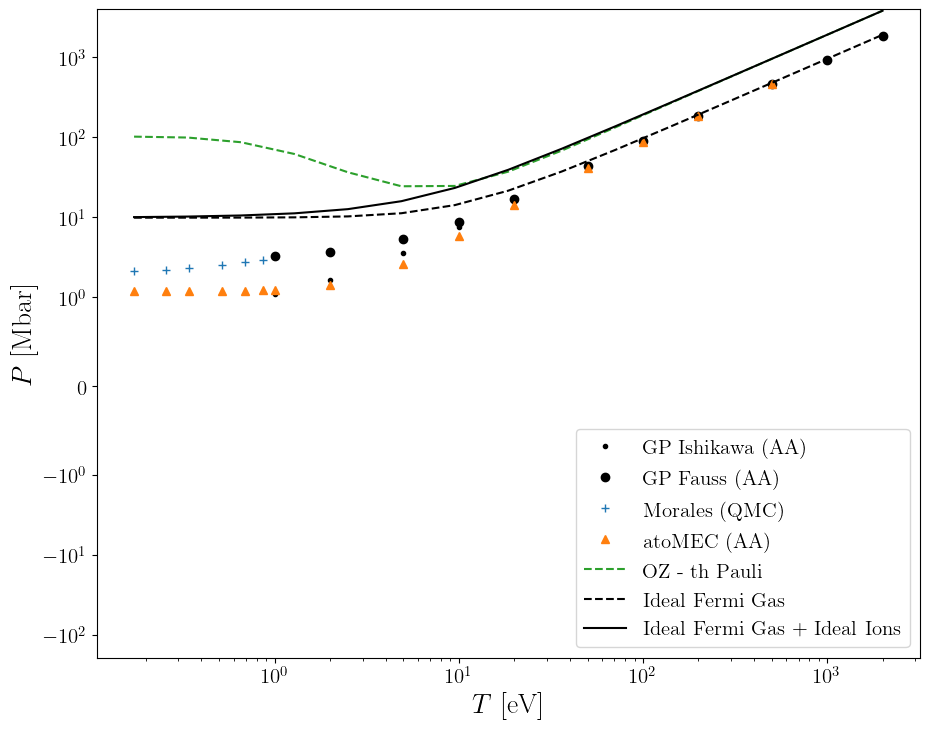

In [69]:

fig, axs = plt.subplots( figsize=(10,8))
axs = np.array([axs])
# fig.suptitle(r"$T_i $ eV", fontsize=25, y=0.9)

#Plot GP data 
axs[0].plot(GP_Te_eV, GP_PMbar_1, 'k.', label='GP Ishikawa (AA)')
axs[0].plot(GP_Te_eV, GP_PMbar_2, 'ko', label='GP Fauss (AA)')

#Plot Morales data
axs[0].plot(Morales_TeV, Morales_PMbar, '+', label='Morales (QMC)')

#Plot atoMEC data
axs[0].plot(atoMEC_TeV, atoMEC_PMbar, '^', label='atoMEC (AA)')

# Plot Pressure ratio
p_type=2
# axs[0].plot(Te_eV_list, P_list_1[:,p_type], label=name1)
# axs[0].plot(Te_eV_list, P_list_2[:,p_type], label=name2)
axs[0].plot(Te_eV_list, P_list_3[:,p_type],'--', label=name3)
# axs[0].plot(Te_eV_list, P_list_3[:,0],'--', label="CMHNC - e")
# axs[0].plot(Te_eV_list, P_list_3[:,1],'--', label="CMHNC - i")
# axs[0].plot(Te_eV_list, P_list_3[:,2],'--', label="CMHNC - e+i")
# axs[0].plot(Te_eV_list, P_list_4[:,p_type],'--.', label=name4)

# Plot Fermi Pressure
Pe_ideal_Mbar = [P_Ideal_Fermi_Gas(Te_eV*eV_to_AU, ni_AU)*AU_to_bar/1e6 for Te_eV in Te_eV_list]
Pi_ideal_Mbar = Ti_eV_list*eV_to_AU*ni_AU*AU_to_bar/1e6

axs[0].plot(Te_eV_list, Pe_ideal_Mbar,'k--', label="Ideal Fermi Gas"  ) 
axs[0].plot(Te_eV_list, Pe_ideal_Mbar + Pi_ideal_Mbar,'k-', label="Ideal Fermi Gas + Ideal Ions"  ) 

for ax in axs:
    ax.legend(fontsize=15, loc='lower right')
    ax.set_xscale('log')
    ax.set_yscale('symlog', linthresh=1)
    # ax.set_yscale('log')
    # ax.set_ylim(0, 20)
    ax.set_ylabel(r"$P$ [Mbar]", fontsize=20)
    ax.set_xlabel(r"$T$ [eV]", fontsize=20)
    ax.tick_params(labelsize=15)
plt.tight_layout()

#### Plot Pressure over Ideal Pressure

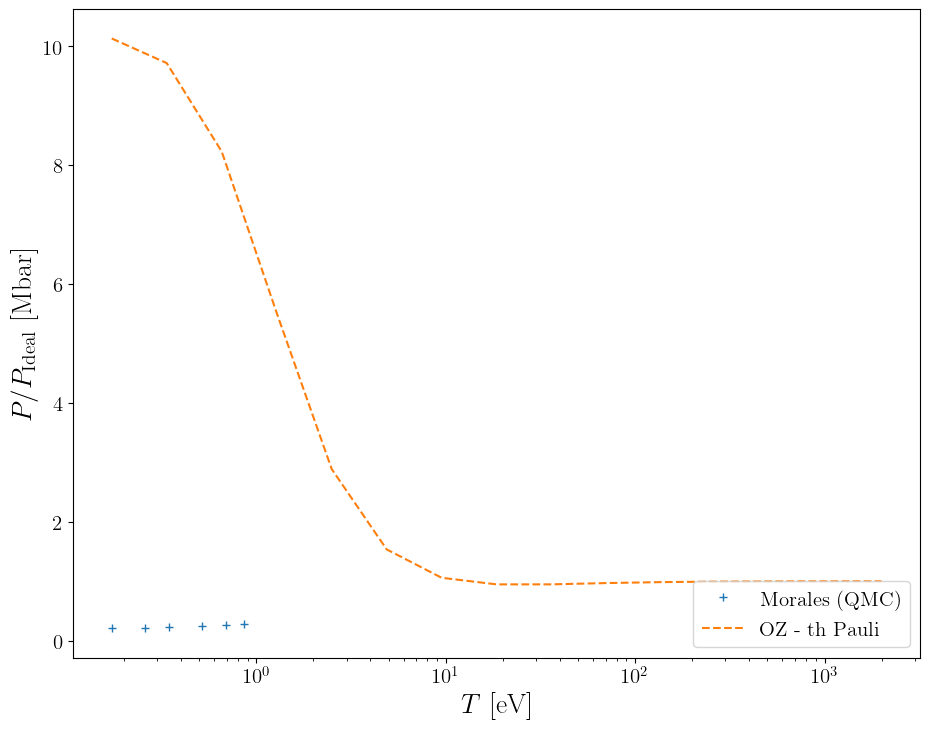

In [70]:
fig, axs = plt.subplots( figsize=(10,8))
axs = np.array([axs])
# fig.suptitle(r"$T_i $ eV", fontsize=25, y=0.9)

# Plot Fermi Pressure
P_ideal_Mbar_func = lambda Te_eV, Ti_eV: P_Ideal_Fermi_Gas(Te_eV*eV_to_AU, ni_AU)*AU_to_bar/1e6 + Ti_eV*eV_to_AU*ni_AU*AU_to_bar/1e6

#Plot Morales data
axs[0].plot(Morales_TeV, Morales_PMbar/[P_ideal_Mbar_func(T_eV, T_eV) for T_eV in Morales_TeV], '+', label='Morales (QMC)')

# Plot Pressure ratio
# axs[0].plot(Te_eV_list, P_list_1[:,2]/(Pe_ideal_Mbar + Pi_ideal_Mbar), label=name1)
# axs[0].plot(Te_eV_list, P_list_2[:,2]/(Pe_ideal_Mbar + Pi_ideal_Mbar), label=name2)
axs[0].plot(Te_eV_list, P_list_3[:,2]/(Pe_ideal_Mbar + Pi_ideal_Mbar),'--', label=name3)
# axs[0].plot(Te_eV_list, P_list_4[:,2]/(Pe_ideal_Mbar + Pi_ideal_Mbar),'--.', label=name4)


for ax in axs:
    ax.legend(fontsize=15, loc='lower right')
    ax.set_xscale('log')
    # ax.set_yscale('symlog', linthresh=1)
    # ax.set_yscale('log')
    # ax.set_ylim(0, 20)
    ax.set_ylabel(r"$P/P_{\rm Ideal}$ [Mbar]", fontsize=20)
    ax.set_xlabel(r"$T$ [eV]", fontsize=20)
    ax.tick_params(labelsize=15)
plt.tight_layout()

### Energy per Atom

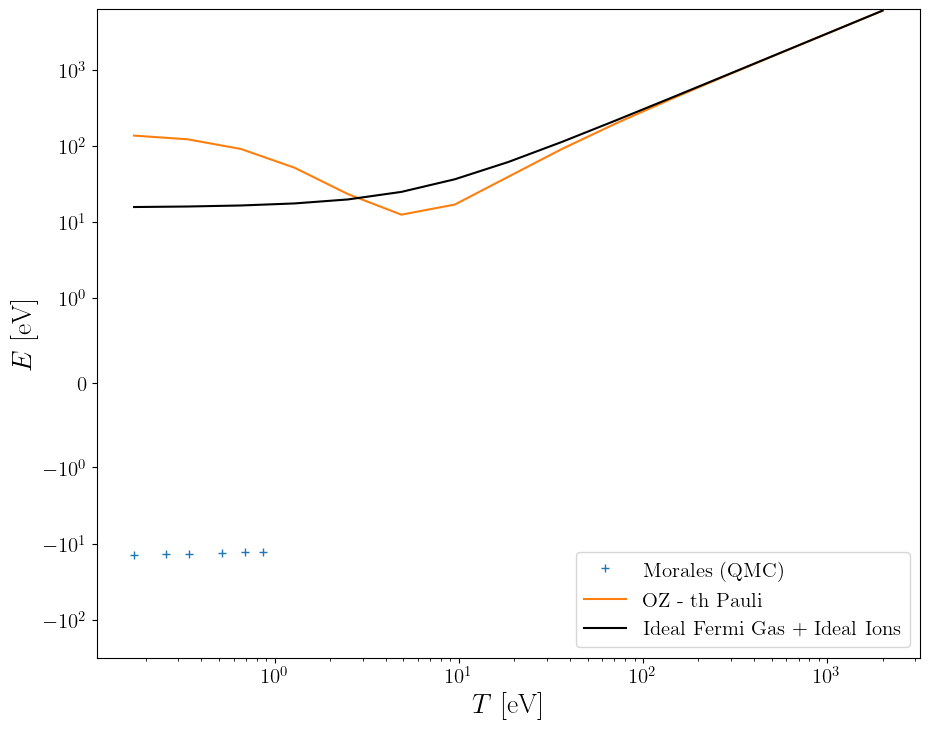

In [71]:
from hnc.hnc.misc import Fermi_Energy

fig, axs = plt.subplots( figsize=(10,8))
axs = np.array([axs])
# fig.suptitle(r"$T_i $ eV", fontsize=25, y=0.9)

#Plot Morales data
axs[0].plot(Morales_TeV, Morales_EAU*AU_to_eV, '+', label='Morales (QMC)')

# Plot Energy
p_type=3
# axs[0].plot(Te_eV_list, P_list_1[:,p_type], label=name1)
# axs[0].plot(Te_eV_list, P_list_2[:,p_type], label=name2)
axs[0].plot(Te_eV_list, P_list_3[:,p_type], label=name3)
# axs[0].plot(Te_eV_list, P_list_4[:,p_type],'--.', label=name4)

# Plot Fermi Pressure
E_ideal_eV_func = lambda Te_eV, Ti_eV: E_Ideal_Fermi_Gas(Te_eV*eV_to_AU, ni_AU)*AU_to_eV + 3/2*Ti_eV
E_ideal_eV_func = np.vectorize(E_ideal_eV_func)

Ee_ideal_eV = [E_Ideal_Fermi_Gas(Te_eV*eV_to_AU, ni_AU)*AU_to_eV for Te_eV in Te_eV_list]
Ei_ideal_eV = 3/2*Ti_eV_list

# axs[0].plot(Te_eV_list, Ee_ideal_eV,'k--', label="Ideal Fermi Gas"  ) 
# axs[0].plot(Te_eV_list, 3/5*Fermi_Energy(ni_AU)*np.ones_like(Te_eV_list)*AU_to_eV,'k--.', label="Degnerate Fermi Gas"  ) 
# axs[0].plot(Te_eV_list, Ei_ideal_eV,'k-.', label="Ideal Gas"  ) 
axs[0].plot(Te_eV_list, Ee_ideal_eV + Ei_ideal_eV,'k-', label="Ideal Fermi Gas + Ideal Ions"  ) 

for ax in axs:
    ax.legend(fontsize=15, loc='lower right')
    ax.set_xscale('log')
    ax.set_yscale('symlog', linthresh=1)
    # ax.set_yscale('log')
    # ax.set_ylim(0, 20)
    ax.set_ylabel(r"$E$ [eV]", fontsize=20)
    ax.set_xlabel(r"$T$ [eV]", fontsize=20)
    ax.tick_params(labelsize=15)
plt.tight_layout()

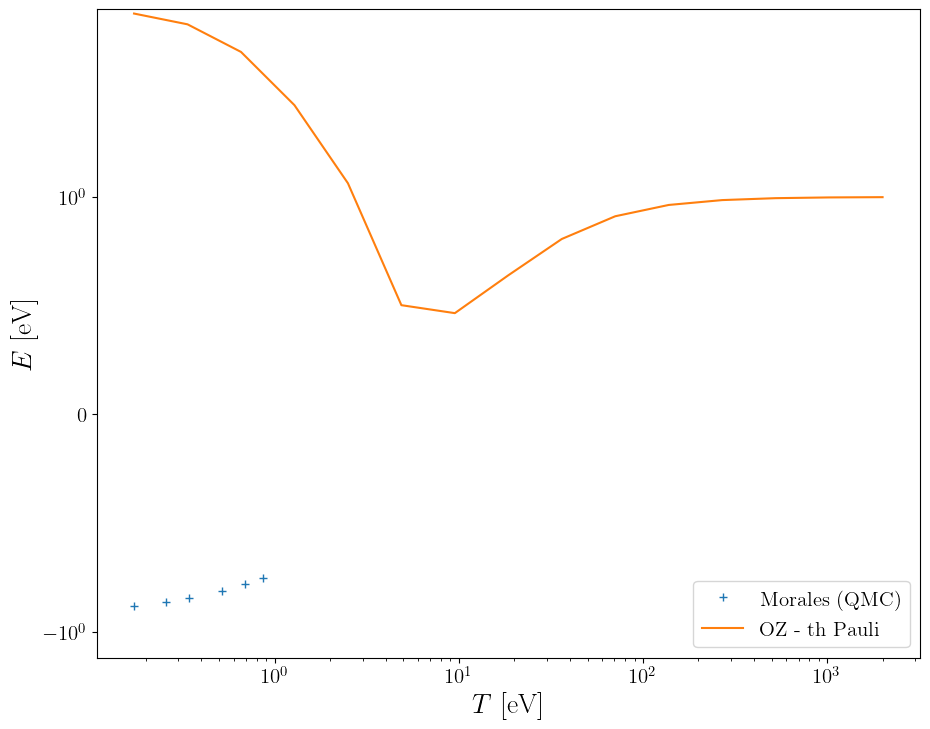

In [72]:
from hnc.hnc.misc import Fermi_Energy

fig, axs = plt.subplots( figsize=(10,8))
axs = np.array([axs])
# fig.suptitle(r"$T_i $ eV", fontsize=25, y=0.9)

#Plot Morales data
axs[0].plot(Morales_TeV, Morales_EAU*AU_to_eV/E_ideal_eV_func(Morales_TeV,Morales_TeV), '+', label='Morales (QMC)')

# Plot Energy
p_type=3
# axs[0].plot(Te_eV_list, P_list_1[:,p_type], label=name1)
# axs[0].plot(Te_eV_list, P_list_2[:,p_type], label=name2)
axs[0].plot(Te_eV_list, P_list_3[:,p_type]/E_ideal_eV_func(Te_eV_list,Te_eV_list), label=name3)
# axs[0].plot(Te_eV_list, P_list_4[:,p_type],'--.', label=name4)

for ax in axs:
    ax.legend(fontsize=15, loc='lower right')
    ax.set_xscale('log')
    ax.set_yscale('symlog', linthresh=1)
    # ax.set_yscale('log')
    # ax.set_ylim(0, 20)
    ax.set_ylabel(r"$E$ [eV]", fontsize=20)
    ax.set_xlabel(r"$T$ [eV]", fontsize=20)
    ax.tick_params(labelsize=15)
plt.tight_layout()

# Getting Energy Right at Low T

In [73]:
plasma_5 = lambda T_eV: PLASMA(Z, A, ni_cc, T_eV, T_eV, Zbar=Z, find_βuee=True,
                 βu_options = {'add_bridge':True,'bridge':'yukawa', 'pseudopotential':False}, 
                 qsp_options= {'r_c':0,'which_Tij':'thermal'},
                 hnc_options= {'kappa_multiscale':10, 'R_max':100,'N_bins':20000, 
                               'h_max':2e2,'oz_method':'standard'},
                 hnc_solve_options={'alpha_Picard':0.5, 'num_iterations':1e4})

plasma_new = plasma_5(2000 / eV_to_K)
plasma_new.run_hnc()


Te_in_eV: 0.172
Ti_in_eV: 0.172
0: Initial condition Total Error: 5.194e+00
Exiting status 0, reverting to best index so far: 846
Final iter:847, Total Error: 9.837e-09


In [74]:
plasma_new.hnc.total_energy_density()

4.621928799309071

In [75]:
E_hnc_to_eV( plasma_new.hnc.total_energy_density()) 

526.7934130522531

In [76]:
plasma_new.hnc.excess_energy_density_matrix(), np.sum(plasma_new.hnc.excess_energy_density_matrix()), plasma_new.hnc.ideal_energy_density()

(array([[ 1286.69326603, -1286.81742888],
        [-1286.81742888,  1291.42498383]]),
 4.483392104242057,
 0.13853669506701424)

In [ ]:
def plot_g_all_species(plasma, data_to_compare=None, data_names=None, gmax=None):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,8))
    fig.suptitle("Radial Distribution Function for all Species", fontsize=20, y=1)

    for i in range(plasma.N_species):
        for j in range(plasma.N_species):
            ax.plot(plasma.r_array, plasma.h_r_matrix[i,j]+1,'--.', label=plasma.name_matrix[i][j] + r", $\Gamma_{{ {0},{1} }}$ = {2:.2f}".format(i,j,plasma.Gamma[i][j]) )

    if data_to_compare:
        for file_name, label in zip(data_to_compare, data_names):
            r_datas, g_datas = np.array(read_csv(file_name, delimiter=',', header=1)).T
            ax.plot(r_datas, g_datas, '-', label=label)
            ax.legend(fontsize=15)

    if gmax:
        ax.set_ylim(0, gmax)

    ax.tick_params(labelsize=20)
    ax.set_xlabel(r"$r/r_s$", fontsize=20)
    ax.set_xlim(plasma.del_r, 10)
    ax.set_ylabel(r"$g(r/r_s)$", fontsize=20)
    ax.set_ylim(0, 5)
    ax.tick_params(labelsize=15)
    ax.legend(fontsize=20, loc = 'upper left')

    ax.set_xscale('log')
    
    # plt.tight_layout()
    plt.show()

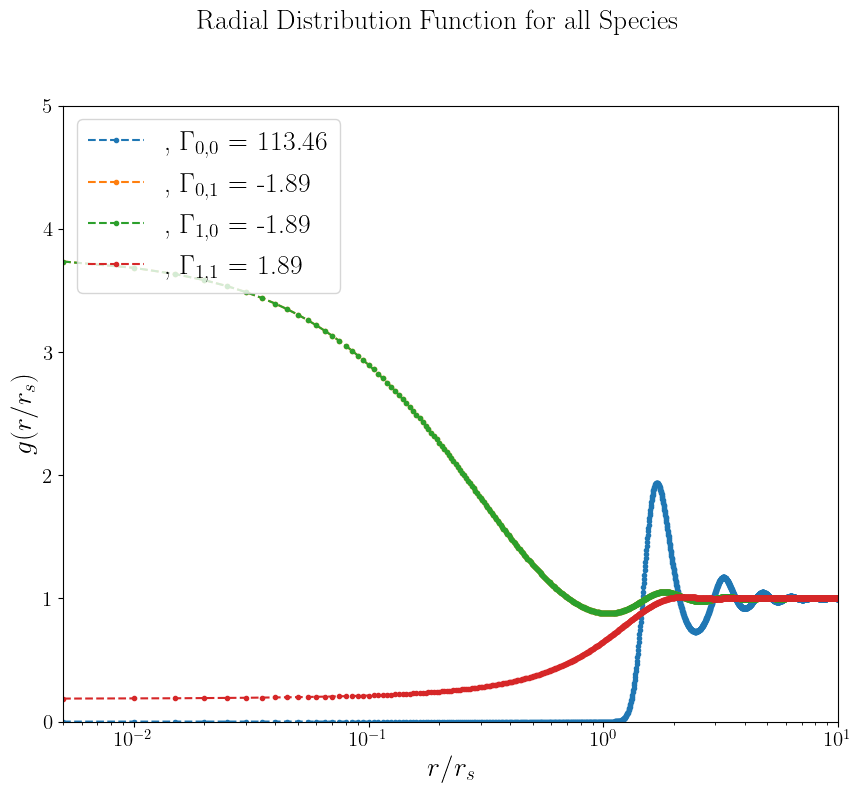

In [43]:
plot_g_all_species(plasma_new.hnc)

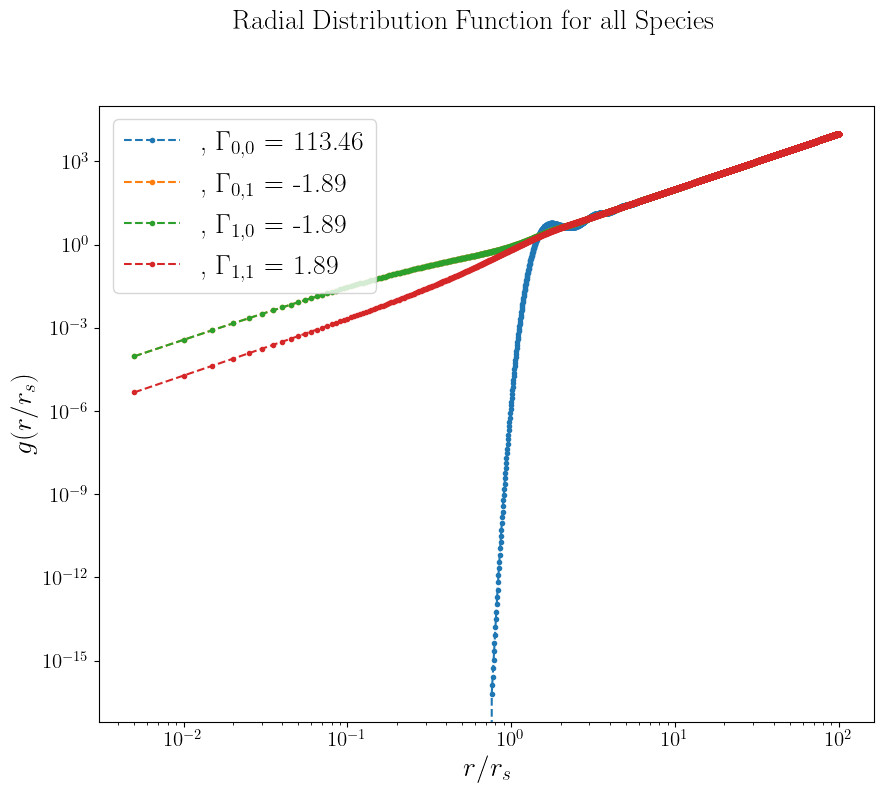

In [48]:
def plot_gr2_all_species(plasma, data_to_compare=None, data_names=None, gmax=None):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,8))
    fig.suptitle("Radial Distribution Function for all Species", fontsize=20, y=1)

    for i in range(plasma.N_species):
        for j in range(plasma.N_species):
            ax.plot(plasma.r_array, (plasma.h_r_matrix[i,j]+1)*plasma.r_array**2,'--.', label=plasma.name_matrix[i][j] + r", $\Gamma_{{ {0},{1} }}$ = {2:.2f}".format(i,j,plasma.Gamma[i][j]) )

    if data_to_compare:
        for file_name, label in zip(data_to_compare, data_names):
            r_datas, g_datas = np.array(read_csv(file_name, delimiter=',', header=1)).T
            ax.plot(r_datas, g_datas, '-', label=label)
            ax.legend(fontsize=15)

    if gmax:
        ax.set_ylim(0, gmax)

    ax.tick_params(labelsize=20)
    ax.set_xlabel(r"$r/r_s$", fontsize=20)
    # ax.set_xlim(plasma.del_r, 10)
    ax.set_ylabel(r"$g(r/r_s)$", fontsize=20)
    # ax.set_ylim(0, 5)
    ax.tick_params(labelsize=15)
    ax.legend(fontsize=20, loc = 'upper left')

    ax.set_xscale('log')
    ax.set_yscale('log')
    
    # plt.tight_layout()
    plt.show()
plot_gr2_all_species(plasma_new.hnc)

In [ ]:
from scipy.integrate import simpson
def excess_energy_density_matrix(hnc):

    g_matrix = hnc.h_r_matrix+1
    rho_matrix = hnc.rho[:,np.newaxis]*hnc.rho[np.newaxis,:]
    r = hnc.r_array[np.newaxis,np.newaxis,:]
    dr = hnc.del_r
    
    u_matrix = hnc.βu_r_matrix*hnc.Temp_matrix[:,:,np.newaxis]
    u_matrix = np.array([[1/hnc.r_array,-1/hnc.r_array],[-1/hnc.r_array,1/hnc.r_array]])
    print(u_matrix.shape)
    
    # u_ex_matrix = np.sum(2*π*rho_matrix[:,:,np.newaxis]*u_matrix*g_matrix*r**2*dr,axis=2)
    u_ex_matrix = simpson(2*π*rho_matrix[:,:,np.newaxis]*u_matrix*(g_matrix)*r**2, r , axis=2)

    return u_ex_matrix
E_ex_matrix = excess_energy_density_matrix(plasma_new.hnc) 
E_ex_matrix, np.sum(E_ex_matrix), E_hnc_to_eV(np.sum(E_ex_matrix))